# Dynamics & Causal Perturbations in RNNs

In [19]:

import os, json, time, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, Markdown

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

UPLOADED_SCRIPT_PATH = "./psychrnn_perceptualdiscrimination_noise_comparison.py"
if Path(UPLOADED_SCRIPT_PATH).exists():
    display(Markdown(f"**Found uploaded script:** `{UPLOADED_SCRIPT_PATH}`"))
else:
    display(Markdown(f"**No uploaded script found at** `{UPLOADED_SCRIPT_PATH}`"))


Device: cuda


**No uploaded script found at** `./psychrnn_perceptualdiscrimination_noise_comparison.py`

In [20]:

def set_seed(seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def savefig(path):
    plt.savefig(path, dpi=150, bbox_inches='tight')
    print("Saved:", path)


In [21]:

def generate_batch(batch_size, T, coherence, stim_std=1.0, input_dim=2, device='cpu'):
    labels = np.random.choice([0,1], size=(batch_size,))
    x = np.random.randn(batch_size, T, input_dim) * stim_std
    for i, lab in enumerate(labels):
        x[i, :, lab] += coherence
    x_t = torch.tensor(x, dtype=torch.float32, device=device)
    y_t = torch.tensor(labels, dtype=torch.long, device=device)
    return x_t, y_t


In [22]:

class RNNCausal(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=80, output_dim=2,
                 rec_noise_std=0.0, gate=True, dale=True, dale_exc_frac=0.8, device='cpu'):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.rec_noise_std = rec_noise_std
        self.gate = gate
        self.dale = dale
        self.device = device

        # input weights: we will treat these as parameters (hidden x input)
        self.W_in = nn.Parameter(torch.randn(hidden_dim, input_dim) * (1.0/np.sqrt(input_dim)))
        self.b_in = nn.Parameter(torch.zeros(hidden_dim))

        # recurrent raw weights (hidden x hidden)
        self.W_rec_raw = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * (1.0/np.sqrt(hidden_dim)))
        self.b_rec = nn.Parameter(torch.zeros(hidden_dim))

        # output layer
        self.W_out = nn.Linear(hidden_dim, output_dim)

        if self.gate:
            self.W_gate = nn.Parameter(torch.randn(hidden_dim, input_dim) * (1.0/np.sqrt(input_dim)))
            self.b_gate = nn.Parameter(torch.zeros(hidden_dim))

        if self.dale:
            n_exc = int(round(dale_exc_frac * hidden_dim))
            signs = np.array([1]*n_exc + [-1]*(hidden_dim-n_exc))
            np.random.shuffle(signs)
            self.register_buffer('dale_sign', torch.tensor(signs, dtype=torch.float32).to(device))
        else:
            self.register_buffer('dale_sign', torch.ones(hidden_dim, dtype=torch.float32).to(device))

        self.activation = torch.tanh

    def effective_Wrec(self):
        # enforce non-negative columns times sign -> outgoing behavior: rows are source->target
        W_abs = torch.abs(self.W_rec_raw)  # >=0
        # apply sign to columns so that outgoing weights from neuron i have sign dale_sign[i]
        W = W_abs * self.dale_sign.unsqueeze(1)  # shape (hidden, hidden)
        return W  # shape (hidden, hidden); used as W_rec (source rows -> target cols)

    def forward(self, x, return_hidden=False, Wrec_override=None, clamp_mask=None, clamp_values=None, inject_noise=None):
        # x: (batch, T, input_dim)
        batch, T, _ = x.size()
        h = torch.zeros(batch, self.hidden_dim, device=x.device)
        hs = []
        # allow override (for lesion experiments) - Wrec_override shape (hidden, hidden) if provided
        W_rec = Wrec_override if Wrec_override is not None else self.effective_Wrec()
        for t in range(T):
            xt = x[:, t, :]
            inp = torch.matmul(xt, self.W_in.t()) + self.b_in  # (batch, hidden)
            if self.gate:
                g = torch.sigmoid(torch.matmul(xt, self.W_gate.t()) + self.b_gate)
                inp = inp * g
            # recurrent: h @ W_rec -> (batch, hidden)
            rec = torch.matmul(h, W_rec) + self.b_rec
            h = self.activation(inp + rec)
            # apply clamp/hold: mask of shape (hidden,) or (batch,hidden)
            if clamp_mask is not None and clamp_values is not None:
                # clamp_mask: boolean tensor shape (hidden,) or (batch,hidden)
                h = torch.where(clamp_mask, clamp_values, h)
            # inject additive noise into selected neurons (tensor same shape as h)
            if inject_noise is not None:
                h = h + inject_noise
            if self.rec_noise_std and self.training:
                h = h + torch.randn_like(h) * float(self.rec_noise_std)
            hs.append(h.unsqueeze(1))
        hs = torch.cat(hs, dim=1)
        logits = self.W_out(hs[:, -1, :])
        if return_hidden:
            return logits, hs
        return logits


In [23]:

def compute_accuracy(model, coherence, n_trials=256, batch_size=64, T=40, stim_std=1.0, device='cpu', **forward_kwargs):
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        while total < n_trials:
            b = min(batch_size, n_trials-total)
            x, y = generate_batch(b, T, coherence, stim_std=stim_std, device=device)
            logits = model(x, **forward_kwargs)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += b
    return correct/total

def psychometric_curve(model, coherences, n_trials_each=300, batch_size=64, T=40, stim_std=1.0, device='cpu', **fw):
    accs = []
    for c in coherences:
        accs.append(compute_accuracy(model, c, n_trials=n_trials_each, batch_size=batch_size, T=T, stim_std=stim_std, device=device, **fw))
    return np.array(accs)


In [24]:

def fit_common_pca(models, names, coherence=0.4, T=40, trials_per_model=10, device='cpu'):
    all_h = []
    with torch.no_grad():
        for name, model in zip(names, models):
            model.eval()
            for _ in range(trials_per_model):
                x, y = generate_batch(1, T, coherence, device=device)
                _, hs = model(x, return_hidden=True)
                all_h.append(hs[0].cpu().numpy())
    all_h = np.concatenate(all_h, axis=0)
    pca = PCA(n_components=3)
    pca.fit(all_h)
    return pca

def compute_centroid_distance(model, coherence=0.4, n_trials=200, batch_size=64, T=40, device='cpu'):
    # compute centroids of final hidden states for label 0 and 1
    model.eval()
    Hs = {0: [], 1: []}
    with torch.no_grad():
        total = 0
        while total < n_trials:
            b = min(batch_size, n_trials - total)
            x, y = generate_batch(b, T, coherence, device=device)
            _, hs = model(x, return_hidden=True)
            final = hs[:, -1, :].cpu().numpy()
            for i,lab in enumerate(y.cpu().numpy()):
                Hs[int(lab)].append(final[i])
            total += b
    mu0 = np.mean(Hs[0], axis=0); mu1 = np.mean(Hs[1], axis=0)
    dist = np.linalg.norm(mu0 - mu1)
    return dist, mu0, mu1


In [25]:

def neuron_saliency(model, coherence=0.4, n_trials=128, batch_size=64, T=40, device='cpu'):
    # compute gradient of correct-class logit wrt final hidden units
    model.eval()
    grads_accum = []
    labels_accum = []
    with torch.no_grad():
        # we'll collect batches, but compute grads with autograd so no torch.no_grad here
        pass
    grads_sum = None
    total = 0
    while total < n_trials:
        b = min(batch_size, n_trials - total)
        x, y = generate_batch(b, T, coherence, device=device)
        # forward with grad tracking
        logits, hs = model(x, return_hidden=True)
        correct_logits = logits.gather(1, y.unsqueeze(1)).squeeze(1)  # (b,)
        # compute gradients of sum(correct_logits) wrt final hidden states hs[:, -1, :]
        grads = torch.autograd.grad(correct_logits.sum(), hs, retain_graph=False)[0]  # shape (b, T, H)
        # take last timestep gradients
        grads_last = grads[:, -1, :].abs().detach().cpu().numpy()  # (b, H)
        if grads_sum is None:
            grads_sum = grads_last.sum(axis=0)
        else:
            grads_sum += grads_last.sum(axis=0)
        total += b
    # average over trials
    saliency = grads_sum / float(n_trials)
    return saliency  # shape (H,)


In [26]:

def lesion_model(model, neuron_indices):
    # create a copy of model and zero outgoing rows of effective W_rec (source -> target)
    import copy
    new_model = copy.deepcopy(model)
    W_raw = new_model.W_rec_raw.data.clone()  # (H, H)
    # zero outgoing connections from each neuron: set row i to 0
    for i in neuron_indices:
        W_raw[i, :] = 0.0
    new_model.W_rec_raw.data.copy_(W_raw)
    return new_model


In [27]:

def run_with_clamp(model, neuron_idx, clamp_value, coherence=0.4, T=40, batch_size=1, device='cpu'):
    # clamp mask shape broadcastable to (batch, hidden)
    clamp_mask = torch.zeros((1, model.hidden_dim), dtype=torch.bool, device=device)
    clamp_mask[0, neuron_idx] = True
    clamp_values = torch.zeros((1, model.hidden_dim), dtype=torch.float32, device=device)
    clamp_values[0, neuron_idx] = clamp_value
    # run single trial and return logits and hidden trajectory
    x, y = generate_batch(batch_size, T, coherence, device=device)
    logits, hs = model(x, return_hidden=True, clamp_mask=clamp_mask, clamp_values=clamp_values)
    return logits, hs, y


In [28]:

def train_simple(seed=0, training_iters=4000, batch_size=64, T=40, hidden_dim=80, lr=1e-3,
                 rec_noise=0.0, gate=True, dale=True, dale_exc_frac=0.8,
                 start_coh=0.6, mode='baseline', eval_interval=200, target_acc=0.8,
                 outdir='out_run', device='cpu', verbose=True):
    set_seed(seed)
    os.makedirs(outdir, exist_ok=True)
    model = RNNCausal(input_dim=2, hidden_dim=hidden_dim, output_dim=2,
                      rec_noise_std=rec_noise, gate=gate, dale=dale, dale_exc_frac=dale_exc_frac, device=device).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    psych_history = []
    eval_coherences = [0.05,0.1,0.2,0.4,0.6,0.8]
    coher = float(start_coh)
    it = 0
    while it < training_iters:
        model.train()
        x, y = generate_batch(batch_size, T, coher, device=device)
        opt.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        losses.append(float(loss.item()))
        it += 1
        if it % eval_interval == 0:
            val_acc = compute_accuracy(model, coher, n_trials=256, batch_size=batch_size, T=T, device=device)
            psych = psychometric_curve(model, eval_coherences, n_trials_each=200, batch_size=batch_size, T=T, device=device)
            psych_history.append({'iter':int(it),'coherence':float(coher),'val_acc':float(val_acc),'psych':psych.tolist()})
            if verbose:
                print(f"[{outdir}] iter {it} | coh {coher:.2f} | loss {loss.item():.4f} | val_acc {val_acc:.3f}")
    final_psych = psychometric_curve(model, eval_coherences, n_trials_each=400, batch_size=batch_size, T=T, device=device)
    torch.save(model.state_dict(), os.path.join(outdir, 'model_state.pt'))
    results = {'losses':list(map(float,losses)),'psych_history':psych_history,'final_psych':list(map(float,final_psych)),'eval_coherences':list(map(float,eval_coherences)),'params':{'seed':seed,'training_iters':training_iters,'hidden_dim':hidden_dim,'rec_noise':rec_noise,'gate':gate,'dale':dale}}
    with open(os.path.join(outdir, 'results.json'),'w') as f:
        json.dump(results,f,indent=2)
    return model, results


[dyn_demo/baseline] iter 200 | coh 0.20 | loss 0.6952 | val_acc 0.570
[dyn_demo/baseline] iter 400 | coh 0.20 | loss 0.7054 | val_acc 0.484
[dyn_demo/baseline] iter 600 | coh 0.20 | loss 0.6548 | val_acc 0.559
[dyn_demo/baseline] iter 800 | coh 0.20 | loss 0.6921 | val_acc 0.512
[dyn_demo/baseline] iter 1000 | coh 0.20 | loss 0.7019 | val_acc 0.543
[dyn_demo/baseline] iter 1200 | coh 0.20 | loss 0.6859 | val_acc 0.582
[dyn_demo/baseline] iter 1400 | coh 0.20 | loss 0.7042 | val_acc 0.531
[dyn_demo/baseline] iter 1600 | coh 0.20 | loss 0.7120 | val_acc 0.602
[dyn_demo/baseline] iter 1800 | coh 0.20 | loss 0.7038 | val_acc 0.582
[dyn_demo/baseline] iter 2000 | coh 0.20 | loss 0.6562 | val_acc 0.645
trained baseline
centroid distance: 1.6588105
top-8 important neurons (by gradient saliency): [10 67 61 49 24 12 13 58]
psych before: [0.4975 0.505  0.605  0.695  0.7475 0.82  ]
psych after (lesion top4): [0.50333333 0.54333333 0.58333333 0.58666667 0.65333333 0.76      ]
Saved: ./dyn_demo/psy

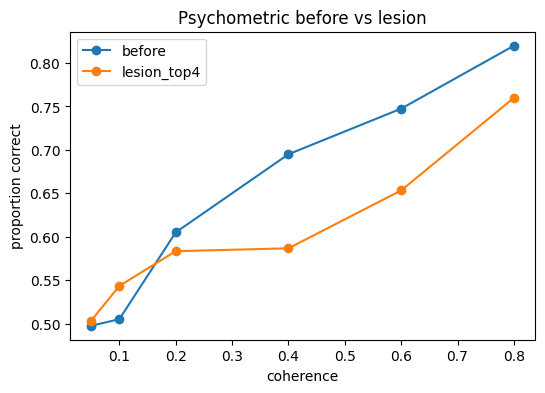

In [39]:

OUT = Path('./dyn_demo'); OUT.mkdir(exist_ok=True)
SEED = 0
TRAIN_ITERS = 2000
BATCH_SIZE = 64
T = 40
HIDDEN = 80
LR = 1e-3

# 1) Train baseline model with gating + dale
model, res = train_simple(seed=SEED, training_iters=TRAIN_ITERS, batch_size=BATCH_SIZE, T=T, hidden_dim=HIDDEN, lr=LR, rec_noise=0.0, gate=True, dale=True, start_coh=0.2, outdir=str(OUT/'baseline'), device=device, verbose=True)
print('trained baseline')

# 2) Compute centroid distance
dist, mu0, mu1 = compute_centroid_distance(model, coherence=0.4, n_trials=300, batch_size=64, T=T, device=device)
print('centroid distance:', dist)

# 3) Compute neuron saliency
sal = neuron_saliency(model, coherence=0.4, n_trials=256, batch_size=64, T=T, device=device)
topk = np.argsort(-sal)[:8]
print('top-8 important neurons (by gradient saliency):', topk)

# 4) Lesion top-4 neurons and evaluate psychometric curves before vs after
topk4 = topk[:4].tolist()
lesioned = lesion_model(model, topk4)
coh = np.array(res['eval_coherences'])
psych_before = np.array(res['final_psych'])
psych_after = psychometric_curve(lesioned, coh, n_trials_each=300, batch_size=64, T=T, device=device)
print('psych before:', psych_before)
print('psych after (lesion top4):', psych_after)


# save some figures
plt.figure(figsize=(6,4))
plt.plot(coh, psych_before, '-o', label='before')
plt.plot(coh, psych_after, '-o', label='lesion_top4')
plt.xlabel('coherence'); plt.ylabel('proportion correct'); plt.title('Psychometric before vs lesion'); plt.legend()
savefig('./dyn_demo/psych_lesion.png')
plt.show()

# 5) PCA visualization (common PCA)



In [40]:
def pca_traj_in_pca(model, pca, coherence=0.4, T=40, device='cpu'):
    model.eval()
    with torch.no_grad():
        x, y = generate_batch(1, T, coherence, device=device)
        _, hs = model(x, return_hidden=True)
        h = hs[0].cpu().numpy()
    traj = pca.transform(h)
    return traj, int(y.cpu().numpy()[0])

Saved: ./dyn_demo/pca_lesion.png


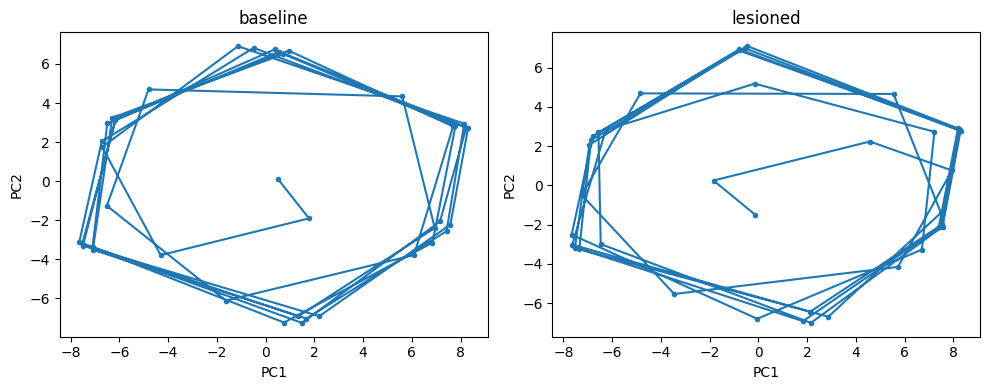

In [41]:
pca = fit_common_pca([model, lesioned], ['baseline','lesioned'], coherence=0.4, T=T, trials_per_model=10, device=device)
plt.figure(figsize=(10,4))
for i, mname in enumerate(['baseline','lesioned']):
    traj, lab = pca_traj_in_pca([model, lesioned][i], pca, coherence=0.4, T=T, device=device)
    ax = plt.subplot(1,2,i+1)
    ax.plot(traj[:,0], traj[:,1], '-o', markersize=3)
    ax.set_title(mname)
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
plt.tight_layout()
savefig('./dyn_demo/pca_lesion.png')
plt.show()

4
Lesion top-4: [0.51       0.55666667 0.59666667 0.60666667 0.73666667 0.71666667]
8
Lesion top-8: [0.50666667 0.56333333 0.62       0.66666667 0.72333333 0.75      ]
8
Lesion top-8: [0.51333333 0.49333333 0.55333333 0.66666667 0.74       0.76333333]
8
Lesion top-8: [0.52666667 0.55333333 0.57333333 0.60333333 0.73333333 0.75666667]
Saved: ./dyn_demo/psych_multi_lesions.png


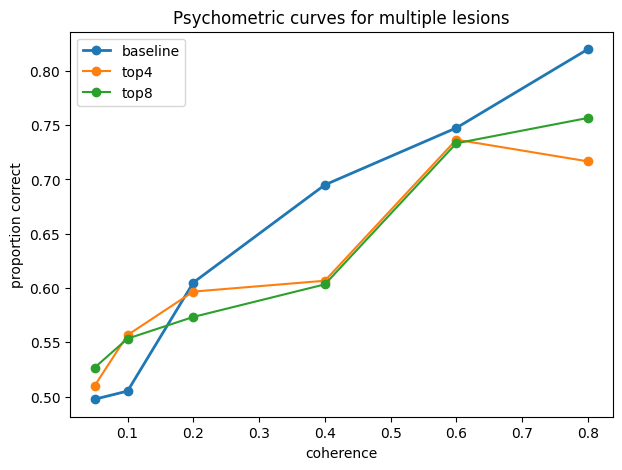

In [42]:
# 4) Lesion multiple sizes automatically: 4, 10, 20, ...
lesion_sizes = [4, 10, 20, 40]      # <-- change this list to whatever you want
coh = np.array(res['eval_coherences'])
psych_before = np.array(res['final_psych'])

lesion_results = {}

for k in lesion_sizes:
    k = min(k, len(topk))           # safety: if you ask for >8 but only computed top-8
    lesion_set = topk[:k].tolist()  # take top-k saliency neurons
    lesioned = lesion_model(model, lesion_set)
    psych = psychometric_curve(lesioned, coh, n_trials_each=300,
                               batch_size=64, T=T, device=device)
    print(k)
    lesion_results[f"top{k}"] = psych
    print(f"Lesion top-{k}:", psych)


# ---- PLOT baseline vs all lesions ----
plt.figure(figsize=(7,5))
plt.plot(coh, psych_before, '-o', label='baseline', linewidth=2)

for name, psych in lesion_results.items():
    plt.plot(coh, psych, '-o', label=name)

plt.xlabel('coherence')
plt.ylabel('proportion correct')
plt.title('Psychometric curves for multiple lesions')
plt.legend()
savefig('./dyn_demo/psych_multi_lesions.png')
plt.show()


In [43]:
def lesion_sweep(model, saliency, ks=[1,2,4,8,16,32],
                 coherences=None, n_trials_each=300,
                 batch_size=64, T=40, device='cpu'):

    if coherences is None:
        coherences = np.array([0.05,0.1,0.2,0.4,0.6,0.8])

    # sort neurons by saliency (descending)
    idx_sorted = np.argsort(-saliency)

    psych_results = {}   # will hold psychometric after each lesion condition

    for k in ks:
        topk = idx_sorted[:k].tolist()
        print(f"\n=== Lesioning top-{k} neurons:", topk)

        lesioned_model = lesion_model(model, topk)

        psych_after = psychometric_curve(
            lesioned_model,
            coherences,
            n_trials_each=n_trials_each,
            batch_size=batch_size,
            T=T,
            device=device
        )

        psych_results[f"top{k}"] = psych_after

    return psych_results, coherences



=== Lesioning top-1 neurons: [10]

=== Lesioning top-2 neurons: [10, 67]

=== Lesioning top-4 neurons: [10, 67, 61, 49]

=== Lesioning top-8 neurons: [10, 67, 61, 49, 24, 12, 13, 58]

=== Lesioning top-32 neurons: [10, 67, 61, 49, 24, 12, 13, 58, 16, 48, 76, 66, 8, 4, 32, 36, 43, 68, 5, 17, 1, 44, 62, 51, 23, 15, 28, 54, 79, 26, 22, 69]
Saved: ./lesion_sweep_psychometrics.png


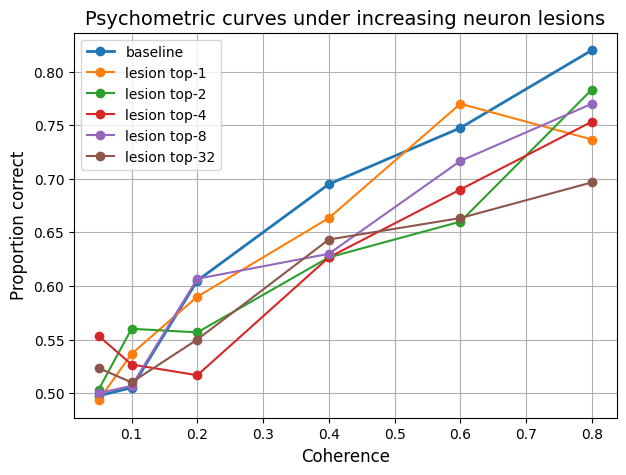

Saved: ./lesion_sweep_psychometrics.png


In [44]:
# Compute baseline psychometric BEFORE lesions
coh = np.array(res['eval_coherences'])
psych_before = np.array(res['final_psych'])

# Run multi-k lesion sweep
ks = [1,2,4,8,32]
psych_after_dict, coherences = lesion_sweep(
    model, saliency=sal, ks=ks,
    n_trials_each=300, batch_size=BATCH_SIZE,
    T=T, device=device
)

# ---------- PLOT ----------
plt.figure(figsize=(7,5))
plt.plot(coherences, psych_before, '-o', linewidth=2, label='baseline')

for k in ks:
    plt.plot(coherences, psych_after_dict[f"top{k}"], '-o', label=f'lesion top-{k}')

plt.xlabel("Coherence", fontsize=12)
plt.ylabel("Proportion correct", fontsize=12)
plt.title("Psychometric curves under increasing neuron lesions", fontsize=14)
plt.legend()
plt.grid(True)
savefig("./lesion_sweep_psychometrics.png")
plt.show()

print("Saved: ./lesion_sweep_psychometrics.png")



=== Lesioning top-1 neurons: [10]

=== Lesioning top-2 neurons: [10, 67]

=== Lesioning top-4 neurons: [10, 67, 61, 49]

=== Lesioning top-8 neurons: [10, 67, 61, 49, 24, 12, 13, 58]

=== Lesioning top-32 neurons: [10, 67, 61, 49, 24, 12, 13, 58, 16, 48, 76, 66, 8, 4, 32, 36, 43, 68, 5, 17, 1, 44, 62, 51, 23, 15, 28, 54, 79, 26, 22, 69]
Saved: ./lesion_sweep_psychometrics.png


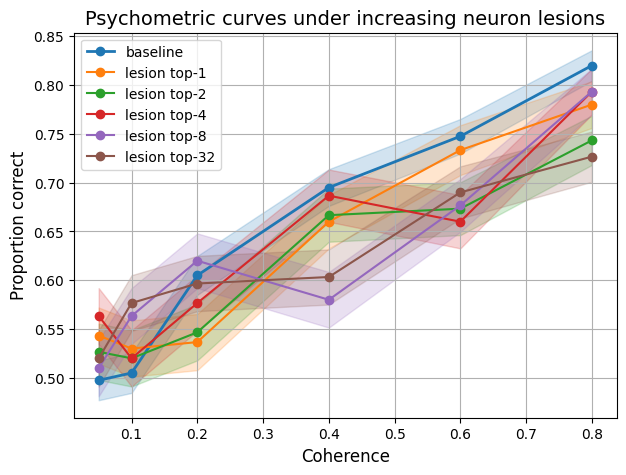

Saved: ./lesion_sweep_psychometrics.png


In [47]:
# Compute baseline psychometric BEFORE lesions
coh = np.array(res['eval_coherences'])
psych_before = np.array(res['final_psych'])

# Run multi-k lesion sweep
ks = [1,2,4,8,32]
# Note: n_trials_each is set to 300 here
psych_after_dict, coherences = lesion_sweep(
    model, saliency=sal, ks=ks,
    n_trials_each=300, batch_size=BATCH_SIZE,
    T=T, device=device
)

# ---------- PLOT ----------
plt.figure(figsize=(7,5))

# 1. Plot Baseline (N=600 from train_model)
n_base = 600
se_base = np.sqrt(psych_before * (1 - psych_before) / n_base)
ci_up_base = np.clip(psych_before + 1 * se_base, 0, 1)
ci_lo_base = np.clip(psych_before - 1 * se_base, 0, 1)

line = plt.plot(coherences, psych_before, '-o', linewidth=2, label='baseline')
plt.fill_between(coherences, ci_lo_base, ci_up_base, color=line[0].get_color(), alpha=0.2)

# 2. Plot Lesions (N=300 from lesion_sweep call above)
n_lesion = 300
for k in ks:
    psych = psych_after_dict[f"top{k}"]

    # --- START CHANGE: CI Calculation ---
    se = np.sqrt(psych * (1 - psych) / n_lesion)
    ci_upper = np.clip(psych + 1 * se, 0, 1)
    ci_lower = np.clip(psych - 1 * se, 0, 1)

    line = plt.plot(coherences, psych, '-o', label=f'lesion top-{k}')
    color = line[0].get_color()
    plt.fill_between(coherences, ci_lower, ci_upper, color=color, alpha=0.2)
    # --- END CHANGE ---

plt.xlabel("Coherence", fontsize=12)
plt.ylabel("Proportion correct", fontsize=12)
plt.title("Psychometric curves under increasing neuron lesions", fontsize=14)
plt.legend()
plt.grid(True)
savefig("./lesion_sweep_psychometrics.png")
plt.show()

print("Saved: ./lesion_sweep_psychometrics.png")

In [46]:
!zip -r lessions.zip ./dyn_demo


  adding: dyn_demo/ (stored 0%)
  adding: dyn_demo/baseline/ (stored 0%)
  adding: dyn_demo/baseline/model_state.pt (deflated 14%)
  adding: dyn_demo/baseline/results.json (deflated 64%)
  adding: dyn_demo/psych_multi_lesions.png (deflated 7%)
  adding: dyn_demo/pca_lesion.png (deflated 5%)
  adding: dyn_demo/psych_lesion.png (deflated 8%)
